# 任务描述：

本示例教程演示如何在IMDB数据集上用RNN网络完成文本分类的任务。

IMDB数据集是一个对电影评论标注为正向评论与负向评论的数据集，共有25000条文本数据作为训练集，25000条文本数据作为测试集。
该数据集的官方地址为： http://ai.stanford.edu/~amaas/data/sentiment/

# 一、环境设置

本示例基于飞桨开源框架2.0版本。

In [ ]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
import paddle.nn as nn

print(paddle.__version__)  # 查看当前版本

# cpu/gpu环境选择，在 paddle.set_device() 输入对应运行设备。
device = paddle.set_device('gpu')

2.0.1


# 二、数据准备
由于IMDB是NLP领域中常见的数据集，飞桨框架将其内置，路径为 `paddle.text.datasets.Imdb`。通过 `mode` 参数可以控制训练集与测试集。

In [16]:
print('loading dataset...')
train_dataset = paddle.text.datasets.Imdb(mode='train')
test_dataset = paddle.text.datasets.Imdb(mode='test')
print('loading finished')

loading dataset...
loading finished


构建了训练集与测试集后，可以通过 `word_idx` 获取数据集的词表。在飞桨框架2.0版本中，推荐使用padding的方式来对同一个batch中长度不一的数据进行补齐，所以在字典中，我们还会添加一个特殊的<pad>词，用来在后续对batch中较短的句子进行填充。

In [ ]:
word_dict = train_dataset.word_idx  # 获取数据集的词表

# add a pad token to the dict for later padding the sequence
word_dict['<pad>'] = len(word_dict)

for k in list(word_dict)[:5]:
    print("{}:{}".format(k.decode('ASCII'), word_dict[k]))

print("...")

for k in list(word_dict)[-5:]:
    print("{}:{}".format(k if isinstance(k, str) else k.decode('ASCII'), word_dict[k]))

print("totally {} words".format(len(word_dict)))

### 2.1 参数设置

在这里我们设置一下词表大小，`embedding`的大小，batch_size，等等

In [ ]:
vocab_size = len(word_dict) + 1
print(vocab_size)
emb_size = 256
seq_len = 200
batch_size = 32
epochs = 2
pad_id = word_dict['<pad>']

classes = ['negative', 'positive']

# 生成句子列表
def ids_to_str(ids):
    # print(ids)
    words = []
    for k in ids:
        w = list(word_dict)[k]
        words.append(w if isinstance(w, str) else w.decode('ASCII'))
    return " ".join(words)

在这里，取出一条数据打印出来看看，可以用 `docs` 获取数据的list，用 `labels` 获取数据的label值，打印出来对数据有一个初步的印象。

In [ ]:
# 取出来第一条数据看看样子。
sent = train_dataset.docs[0]
label = train_dataset.labels[1]
print('sentence list id is:', sent)
print('sentence label id is:', label)
print('--------------------------')
print('sentence list is: ', ids_to_str(sent))
print('sentence label is: ', classes[label])

### 2.2 用padding的方式对齐数据

文本数据中，每一句话的长度都是不一样的，为了方便后续的神经网络的计算，常见的处理方式是把数据集中的数据都统一成同样长度的数据。这包括：对于较长的数据进行截断处理，对于较短的数据用特殊的词`<pad>`进行填充。接下来的代码会对数据集中的数据进行这样的处理。

In [ ]:
# 读取数据归一化处理
def create_padded_dataset(dataset):
    padded_sents = []
    labels = []
    for batch_id, data in enumerate(dataset):
        sent, label = data[0], data[1]
        padded_sent = np.concatenate([sent[:seq_len], [pad_id] * (seq_len - len(sent))]).astype('int32')
        padded_sents.append(padded_sent)
        labels.append(label)
    return np.array(padded_sents), np.array(labels)

# 对train、test数据进行实例化
train_sents, train_labels = create_padded_dataset(train_dataset)
test_sents, test_labels = create_padded_dataset(test_dataset)

# 查看数据大小及举例内容
print(train_sents.shape)
print(train_labels.shape)
print(test_sents.shape)
print(test_labels.shape)

for sent in train_sents[:3]:
    print(ids_to_str(sent))

### 2.3 用Dataset 与 DataLoader 加载
将前面准备好的训练集与测试集用Dataset 与 DataLoader封装后，完成数据的加载。

In [ ]:
class IMDBDataset(paddle.io.Dataset):
    '''
    继承paddle.io.Dataset类进行封装数据
    '''
    def __init__(self, sents, labels):
        self.sents = sents
        self.labels = labels
    
    def __getitem__(self, index):
        data = self.sents[index]
        label = self.labels[index]

        return data, label

    def __len__(self):
        return len(self.sents)
    
train_dataset = IMDBDataset(train_sents, train_labels)
test_dataset = IMDBDataset(test_sents, test_labels)

train_loader = paddle.io.DataLoader(train_dataset, return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = paddle.io.DataLoader(test_dataset, return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)

# 三、模型配置
<b>样本出现的时间顺序对于自然语言处理、语音识别、手写体识别等应用非常重要</b>。
对了适应这种需求，就出现了题主所说的另一种神经网络结构——**循环神经网络RNN**。

本示例中，我们将会使用一个序列特性的RNN网络，在查找到每个词对应的embedding后，简单的取平均，作为一个句子的表示。然后用`Linear`进行线性变换。为了防止过拟合，我们还使用了`Dropout`。

RNN对具有序列特性的数据非常有效，它能挖掘数据中的时序信息以及语义信息，利用了RNN的这种能力，使深度学习模型在解决语音识别、语言模型、机器翻译以及时序分析等NLP领域的问题时有所突破。

在普通的全连接网络或CNN中，每层神经元的信号只能向上一层传播，样本的处理在各个时刻独立，因此又被成为前向神经网络(Feed-forward Neural Networks)。而在RNN中，神经元的输出可以在下一个时间戳直接作用到自身，即第i层神经元在m时刻的输入，除了（i-1）层神经元在该时刻的输出外，还包括其自身在（m-1）时刻的输出！表示成图就是这样的：
![](https://ai-studio-static-online.cdn.bcebos.com/790df6df4f63416ca7882eec1f2fbc21d656faa3046948c7816cadd16a19a32f)

可以看到在隐含层节点之间增加了互连。为了分析方便，我们常将RNN在时间上进行展开，得到如图所示的结构：


![](https://ai-studio-static-online.cdn.bcebos.com/ff4d9c4c50594ee98c81b3c00466bb38dfc254d649cd4d18b7e00fac076c4c65)

（t+1）时刻网络的最终结果O(t+1)是该时刻输入和所有历史共同作用的结果！这就达到了对时间序列建模的目的。


In [13]:
import paddle.nn as nn
import paddle

# 定义RNN网络
class MyRNN(paddle.nn.Layer):
    def __init__(self):
        super(MyRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 256)
        self.rnn = nn.SimpleRNN(256, 256, num_layers=2, direction='forward',dropout=0.5)
        self.linear = nn.Linear(in_features=256*2, out_features=2)
        self.dropout = nn.Dropout(0.5)
    

    def forward(self, inputs):
        emb = self.dropout(self.embedding(inputs))
        #output形状大小为[batch_size,seq_len,num_directions * hidden_size]
        #hidden形状大小为[num_layers * num_directions, batch_size, hidden_size]
        #把前向的hidden与后向的hidden合并在一起
        output, hidden = self.rnn(emb)
        hidden = paddle.concat((hidden[-2,:,:], hidden[-1,:,:]), axis = 1)
        #hidden形状大小为[batch_size, hidden_size * num_directions]
        hidden = self.dropout(hidden)
        return self.linear(hidden) 

# 四、模型训练

In [14]:
# 可视化定义
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epoch: 0, batch_id: 0, loss is: [0.68269825]
epoch: 0, batch_id: 500, loss is: [0.7189135]
[validation] accuracy: 0.5136043429374695, loss: 0.7002714276313782
epoch: 1, batch_id: 0, loss is: [0.73439085]
epoch: 1, batch_id: 500, loss is: [0.71715605]
[validation] accuracy: 0.49147728085517883, loss: 0.7526456117630005


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


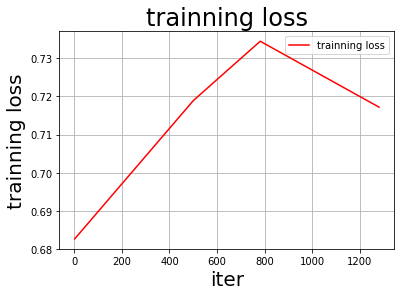

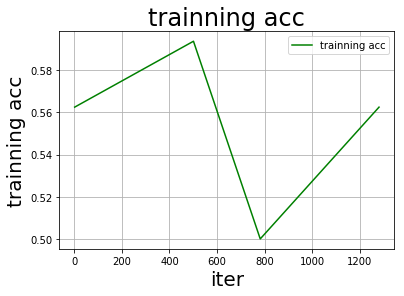

In [15]:
# 对模型进行封装
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    steps = 0
    Iters, total_loss, total_acc = [], [], []

    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 500 == 0:  # 500个epoch输出一次结果
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

        # 保存模型
        paddle.save(model.state_dict(),str(epoch)+"_model_final.pdparams")
    
    # 可视化查看
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
        
model = MyRNN()
train(model)

# 五、模型评估

In [19]:
'''
模型评估
'''
model_state_dict = paddle.load('1_model_final.pdparams')  # 导入模型
model = MyRNN()
model.set_state_dict(model_state_dict) 
model.eval()
accuracies = []
losses = []

for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    label = data[1]

    logits = model(sent)
    loss = paddle.nn.functional.cross_entropy(logits, label)
    acc = paddle.metric.accuracy(logits, label)
    
    accuracies.append(acc.numpy())
    losses.append(loss.numpy())

avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))

[validation] accuracy: 0.49143725633621216, loss: 0.7526697516441345


# 六、模型预测

In [22]:
def ids_to_str(ids):
    words = []
    for k in ids:
        w = list(word_dict)[k]
        words.append(w if isinstance(w, str) else w.decode('UTF-8'))
    return " ".join(words)

label_map = {0:"negative", 1:"positive"}

# 导入模型
model_state_dict = paddle.load('1_model_final.pdparams')
model = MyRNN()
model.set_state_dict(model_state_dict) 
model.eval()

for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    results = model(sent)

    predictions = []
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        labels = label_map[idx]
        predictions.append(labels)
    
    for i,pre in enumerate(predictions):
        print(' 数据: {} \n 情感: {}'.format(ids_to_str(sent[0]), pre))
        break
    break

 数据: island of death is not really a good movie by any standard but it is a curious one imagine if natural born killers had been made 20 years too early as a greek <unk> porn film thats what you get here the <unk> story of a young <unk> british couple cutting a deadly <unk> through the population of a lovely little greek <unk> br ill spare you a detailed <unk> of the plot its not really important except to set up increasingly <unk> or violent sex scenes followed by <unk> brutal murders often <unk> photographed for <unk> by our charming young couple it could have been brilliant in its own sick and nasty way but <unk> br instead i found myself <unk> checking the run time and chapter <unk> to see how much longer the <unk> was going to last <unk> pacing and <unk> bland acting turn even <unk> <unk> into <unk> and <unk> scenes into an <unk> of dull <unk> ah well you cant win em all <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa